In [1]:
%load_ext autoreload
%autoreload 2


import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import constants
import physician_finder as pf
import TP_analysis as tp

sys.path.append("../helpers")
import helpers

# Load UC salary data

In [2]:
physician_salary_data = tp.load_physician_salary_data()

# Webscrapeeeeee

In [8]:
department = "obgyn-MFM"
department = "surgery-trauma"
department = "pediatrics-EM"
year = 2020
site = "UCSF"


# department_url = constants.UCLA_DEPARTMENT_URLS[department]
department_url = constants.UCSF_DEPARTMENT_URLS[department]
print(department_url)

https://pediatrics.ucsf.edu/1619786/emergency-medicine-faculty?combine=&page={page_number}


In [11]:
provider_data = pf.get_providers(department_url).drop_duplicates(["name"])
provider_data.head()
len(provider_data)
provider_data

,index,name,degree
0,0,Nisa Atigapramoj,MD
1,1,Steven Bin,MD
2,2,Carol Chen,MD
3,3,Rajesh Daftary,"MD, MPH"
4,4,Nicolaus Glomb,"MD, MPH"
5,5,Israel Green-Hopkins,MD
6,6,Jacqueline Grupp-Phelan,"MD, MPH"
7,7,Aaron Kornblith,MD
8,8,Margaret Lin-Martore,MD
9,9,Evelyn Porter,"MD, MS"


In [12]:
from thefuzz import fuzz
from tqdm.notebook import tqdm

In [13]:
names = physician_salary_data["employee_name"].str.lower()

department_salary_df = []
for i, row in tqdm(provider_data.iterrows(), total=len(provider_data)):
    indices = names.apply(fuzz.ratio, args=(row["name"].lower(),))
    df_i = physician_salary_data.loc[indices >= 80].copy()
    if len(df_i) > 0:
        df_i["degree"] = row["degree"]
        df_i["department"] = department
        df_i["ws_name"] = row["name"].lower()
        department_salary_df.append(df_i)

department_salary_df = pd.concat(department_salary_df)

  0%|          | 0/13 [00:00<?, ?it/s]

In [14]:
data = department_salary_df.query("total_pay < 2_500_000").query("total_pay > 120_000")
data = data.loc[data["job_title"].str.contains("prof")]

In [15]:
data["inflation_adjusted_pay"] = (1.03 ** (2023 - data["year"])) * data["total_pay"]

In [16]:
year_data = data.query(f"year == {year}").sort_values("total_pay").drop_duplicates("employee_name")

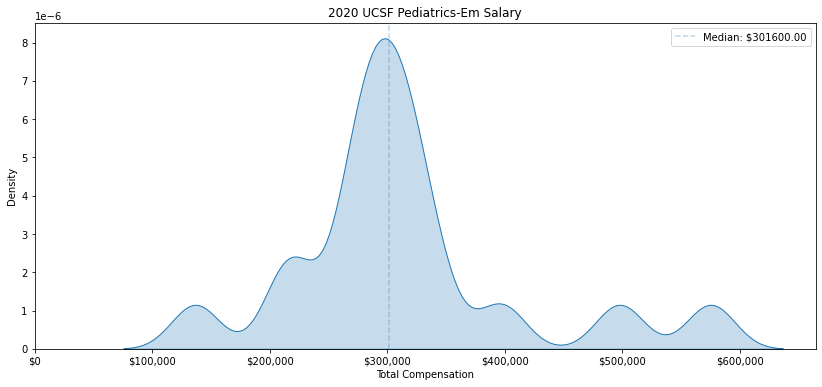

In [17]:
variable = "total_pay"

fig, ax = plt.subplots(figsize=(14, 6))
sns.kdeplot(year_data[variable].values, shade=True, bw_method=.2)
helpers.set_money_axis(ax.xaxis)
ax.set_xlim(0, None)
ax.set_xlabel("Total Compensation")
ax.set_title(f"{year} {site} {department.title()} Salary")
median = np.round(np.median(year_data[variable].values), -2)
ax.axvline(median, color="C0", linestyle="--", alpha=0.3, label=f"Median: ${median:.02f}")
ax.legend();